In [304]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict
from tqdm import tqdm
import networkx as nx
from matplotlib_venn import venn2, venn3
from neteval import gene_mapper as gm
from neteval import query_ensembl as qe
from neteval import query_hgnc as qh
import obonet as obo
import random as rn
import glob
import re

In [305]:
datadir='/cellar/users/snwright/Data/RareCommon/inputs/'
resdir= '/cellar/users/snwright/Data/RareCommon/outputs/netcoloc/'
outdir='/cellar/users/snwright/Data/Transfer/RVC/'
figdir='/cellar/users/snwright/Data/Transfer/RVC/figures/RAVAR_GWASCat/'

In [306]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25

## Load Data

In [307]:
col_names=['TraitR', 'TraitC', 'Network','Transform', 'Norm', 'Mean_NPS', 'Null_mean_NPS', 'P_mean_NPS', 'Size', 'Null_Size', 'P_size' ]

In [308]:
ng_binary1 = pd.read_csv(os.path.join(resdir, 'testing', 'netcoloc_nearestGene_repeat1.tsv'), sep='\t', header=None,names=col_names).fillna({'Norm':'binary'})
ng_binary2 = pd.read_csv(os.path.join(resdir, 'testing/testing2', 'netcoloc_nearestGene_repeat2.tsv'), sep='\t', header=None,
                        names=col_names).fillna({'Norm':'binary'})
ng_binary3 = pd.read_csv(os.path.join(resdir, 'testing/testing3', 'netcoloc_nearestGene_repeat3.tsv'), sep='\t', header=None,names=col_names).fillna({'Norm':'binary'})
ng_q1 = pd.read_csv(os.path.join(resdir, 'testing', 'qnetcoloc_nearestGene_repeat1.tsv'), sep='\t', header=None,names=col_names).fillna({'Norm':'base'})
ng_q2 = pd.read_csv(os.path.join(resdir, 'testing/testing2', 'qnetcoloc_nearestGene_repeat2.tsv'), sep='\t', header=None,names=col_names).fillna({'Norm':'base'})
ng_q3 = pd.read_csv(os.path.join(resdir, 'testing/testing3', 'qnetcoloc_nearestGene_repeat3.tsv'), sep='\t', header=None,names=col_names).fillna({'Norm':'base'})

In [309]:
ng1 = pd.concat([ng_binary1, ng_q1])
ng1 = ng1.assign(repeat=1)
ng2 = pd.concat([ng_binary2, ng_q2])
ng2 = ng2.assign(repeat=2)
ng3 = pd.concat([ng_binary3, ng_q3])
ng3 = ng3.assign(repeat=3)
ng_all = pd.concat([ng1[ng1.Norm.isin(['base', 'binary', 'sum'])], ng2, ng3])
ng_all = ng_all.assign(logp_nps = -1 * np.log10(ng_all.P_mean_NPS.values+1e-250))
ng_all = ng_all.assign(logp_size = -1 * np.log10(ng_all.P_size.values+1e-250))
ng_all = ng_all.assign(SizeOE = ng_all.Size / ng_all.Null_Size)
ng_all = ng_all.assign(Group='NG')

In [310]:
mag_binary1 = pd.read_csv(os.path.join(resdir, 'magma', 'netcoloc_magma103_repeat1.tsv'), sep='\t', header=None,names=col_names).fillna({'Norm':'binary'})
mag_binary2 = pd.read_csv(os.path.join(resdir, 'magma/magma2', 'netcoloc_magma_th103_repeat2.tsv'), sep='\t', header=None,names=col_names).fillna({'Norm':'binary'})
mag_binary3 = pd.read_csv(os.path.join(resdir, 'magma/magma3', 'netcoloc_magma_th103_repeat3.tsv'), sep='\t', header=None,names=col_names).fillna({'Norm':'binary'})
mag_q1 = pd.read_csv(os.path.join(resdir, 'magma', 'qnetcoloc_magma103_repeat1.tsv'), sep='\t', header=None,names=col_names).fillna({'Norm':'base'})
mag_q2 = pd.read_csv(os.path.join(resdir, 'magma/magma2', 'qnetcoloc_magma_th103_repeat2.tsv'), sep='\t', header=None,names=col_names).fillna({'Norm':'base'})
mag_q3 = pd.read_csv(os.path.join(resdir, 'magma/magma3', 'qnetcoloc_magma_th103_repeat3.tsv'), sep='\t', header=None,names=col_names).fillna({'Norm':'base'})

In [311]:
mag1 = pd.concat([mag_binary1, mag_q1])
mag1 = mag1.assign(repeat=1)
mag2 = pd.concat([mag_binary2, mag_q2])
mag2 = mag2.assign(repeat=2)
mag3 = pd.concat([mag_binary3, mag_q3])
mag3 = mag3.assign(repeat=3)
mag_all = pd.concat([mag1[mag1.Norm.isin(['base', 'binary', 'sum'])], mag2, mag3])
mag_all = mag_all.assign(logp_nps = -1 * np.log10(mag_all.P_mean_NPS.values+1e-250))
mag_all = mag_all.assign(logp_size = -1 * np.log10(mag_all.P_size.values+1e-250))
mag_all = mag_all.assign(SizeOE = mag_all.Size / mag_all.Null_Size)
mag_all = mag_all.assign(Group="MAG")

## Export the results

In [313]:
ng_all.to_csv('/cellar/users/snwright/Data/RareCommon/outputs/netcoloc/nearestGene_all_repeat_results.tsv', index=False, sep='\t')
mag_all.to_csv('/cellar/users/snwright/Data/RareCommon/outputs/netcoloc/magma_all_repeat_results.tsv', index=False, sep='\t')

## How consistent are the repeats?

For NPS they cluster first by repeat number

For Size they cluster first by q vs binary, then by repeat number. 


### Mean NPS

Text(0.5, 1.0, 'Mean_NPS')

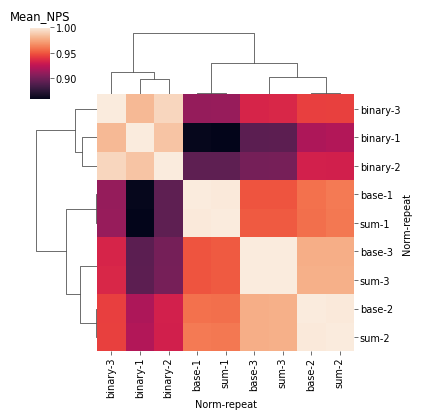

In [298]:
sns.clustermap(mag_all.pivot_table(columns=['Norm', 'repeat'], index='TraitR', values='Mean_NPS').corr(), figsize=(4,4))
plt.title('Mean_NPS')

Text(0.5, 1.0, 'P_NPS')

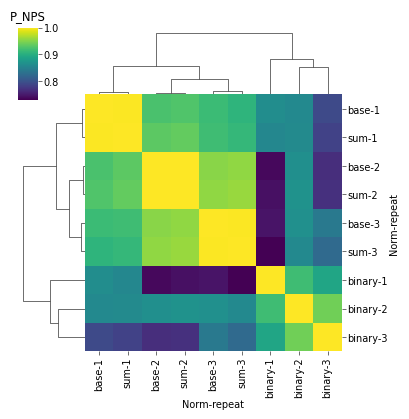

In [299]:
sns.clustermap(mag_all.pivot_table(columns=['Norm', 'repeat'], index='TraitR', values='logp_nps').dropna().corr(), cmap='viridis', figsize=(4,4))
plt.title('P_NPS')

### Size

Text(0.5, 1.0, 'SizeOE')

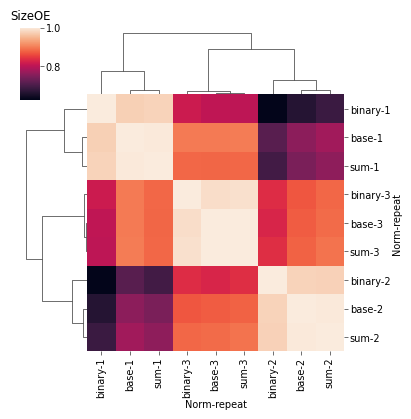

In [300]:
sns.clustermap(mag_all.pivot_table(columns=['Norm', 'repeat'], index='TraitR', values='SizeOE').dropna().corr(), figsize=(4,4))
plt.title('SizeOE')

Text(0.5, 1.0, 'P_size')

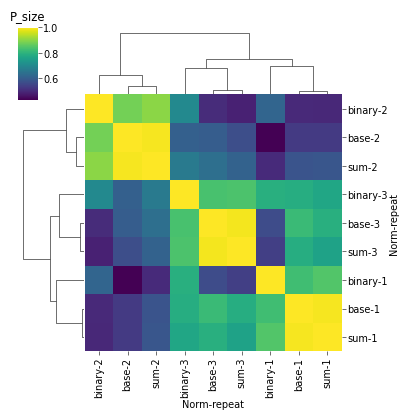

In [301]:
sns.clustermap(mag_all.pivot_table(columns=['Norm', 'repeat'], index='TraitR', values='logp_size').dropna().corr(), cmap='viridis', figsize=(4,4))
plt.title('P_size')

## How consistent are the method rankings?

Are they consistently better?

In [171]:
all_df = pd.concat([ng_all, mag_all])
all_df['EFO'] = all_df.TraitR.apply(lambda x: next((match.group() for match in re.finditer(r'EFO_\d+', x)), None))
all_df['Study'] = all_df.TraitR.apply(lambda x: next((match.group() for match in re.finditer(r'GCST\d+', x)), None))
all_df['StudyEFO'] = all_df['Study'] + ':' + all_df['EFO']

In [222]:
all_df.pivot_table(columns=['Group', 'Norm'], index='StudyEFO', values='logp_nps', aggfunc='mean').dropna()

Group                            MAG                                  NG  \
Norm                            base      binary         sum        base   
StudyEFO                                                                   
GCST006366:EFO_0005213    111.069854   69.304608  104.881791  227.736200   
GCST007459:EFO_0006525    250.000000  198.059019  250.000000  236.580454   
GCST007710:EFO_0009863     68.581565   28.240132   63.880770   46.761631   
GCST008062:EFO_0004741    250.000000   87.046599  250.000000   48.678657   
GCST009414:EFO_0005213     85.980906   49.266062   85.455470  250.000000   
GCST010572:EFO_0010156     81.546583   38.892289   76.225951   51.999915   
GCST90016673:EFO_0010821  142.538312  114.787761  132.669436  185.494695   
GCST90018627:EFO_0004237  250.000000  250.000000  250.000000  108.798327   
GCST90018714:EFO_0000731   11.534990    7.366839   12.339303  191.594944   
GCST90018728:EFO_0004741  215.542087   93.828096  219.610040   36.478219   
GCST90092502:EFO_0007117   32.893091   33.518767   30.257043   60.376834   
GCST90092503:EFO_0007117   61.137137   64.256692   58.517714  131.702026   
GCST90092504:EFO_0007117    0.590871    0.571374    1.135234   33.149010   
GCST90092505:EFO_0007117   14.190144    8.175597   11.834257    0.000159   
GCST90093316:EFO_0004887   36.653438   15.144461   40.649516  179.898360   
GCST90094960:EFO_0008036   54.567525   27.516600   55.153559  250.000000   
GCST90100525:EFO_0006332    0.000000    0.000000    0.000000  250.000000   
GCST90103632:EFO_0004741  250.000000   78.736423  250.000000   88.490417   
GCST90103754:EFO_0004343   14.980985   21.167733   11.981922   18.321168   
GCST90179151:EFO_0006525  250.000000  160.625054  250.000000  127.446169   
GCST90267352:EFO_0010821  102.303611   53.563205  104.803600  250.000000   
GCST90269581:EFO_0021898  250.000000  105.918583  250.000000  189.032457   
GCST90278623:EFO_0004741  136.769821   45.183865  136.441995  132.625711   
GCST90278649:EFO_0004343  169.705071   70.891946  175.661714   24.167007   

Group                                             
Norm                          binary         sum  
StudyEFO                                          
GCST006366:EFO_0005213    184.987383  237.032122  
GCST007459:EFO_0006525    186.375207  239.786988  
GCST007710:EFO_0009863     25.352772   49.672467  
GCST008062:EFO_0004741     67.119700   50.078042  
GCST009414:EFO_0005213    250.000000  250.000000  
GCST010572:EFO_0010156     30.956741   60.718691  
GCST90016673:EFO_0010821   83.333333  179.934377  
GCST90018627:EFO_0004237   13.037939  113.855896  
GCST90018714:EFO_0000731  177.181467  207.117028  
GCST90018728:EFO_0004741   84.719287   35.490581  
GCST90092502:EFO_0007117   47.936502   57.504396  
GCST90092503:EFO_0007117  119.841778  137.898041  
GCST90092504:EFO_0007117   34.599062   34.703446  
GCST90092505:EFO_0007117    0.000595    0.000014  
GCST90093316:EFO_0004887  176.202728  179.429989  
GCST90094960:EFO_0008036  250.000000  250.000000  
GCST90100525:EFO_0006332  250.000000  250.000000  
GCST90103632:EFO_0004741   62.141179   86.177737  
GCST90103754:EFO_0004343   16.024840   19.338544  
GCST90179151:EFO_0006525   86.365985  130.673058  
GCST90267352:EFO_0010821  250.000000  250.000000  
GCST90269581:EFO_0021898  166.536300  199.043700  
GCST90278623:EFO_0004741   95.566152  117.428290  
GCST90278649:EFO_0004343   46.313070   27.091043

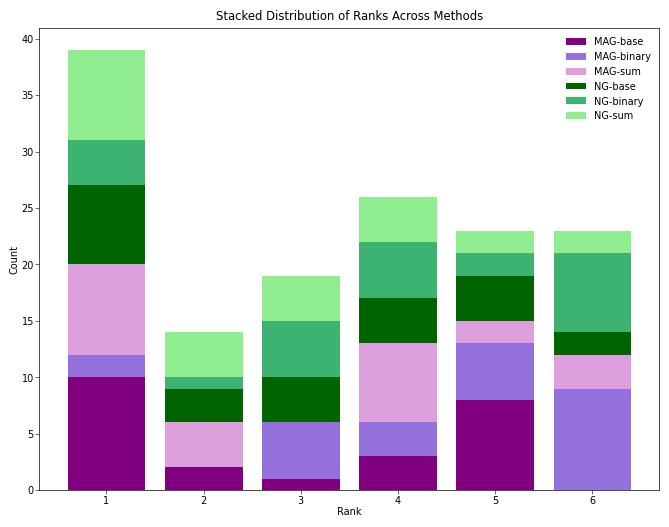

In [221]:
df = all_df.pivot_table(columns=['Group', 'Norm'], index='StudyEFO', values='logp_nps', aggfunc='mean').dropna().rank(ascending=False, axis=1)

def plot_stacked_rank_distribution(df):
    """
    Creates a stacked bar chart showing the distribution of ranks.
    
    Parameters:
        df (pd.DataFrame): MultiIndex DataFrame with ranking values.
    """
    # Rank each row
    ranked_df = df.rank(axis=1, method='min')

    # Define colors for MAG and NG methods
    mag_colors = ['purple', 'mediumpurple', 'plum']
    ng_colors = ['darkgreen', 'mediumseagreen', 'lightgreen']

    # Prepare rank counts for plotting
    rank_counts = {rank: (ranked_df == rank).sum() for rank in range(1, 7)}

    # Stacked bar chart
    x_labels = range(1, 7)
    bottom_mag = np.zeros(len(x_labels))
    bottom_ng = np.zeros(len(x_labels))

    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot MAG methods
    for i, method in enumerate(['base', 'binary', 'sum']):
        values = [rank_counts[rank][('MAG', method)] for rank in x_labels]
        ax.bar(x_labels, values, label=f'MAG-{method}', bottom=bottom_mag, color=mag_colors[i])
        bottom_mag += values

    # Plot NG methods
    for i, method in enumerate(['base', 'binary', 'sum']):
        values = [rank_counts[rank][('NG', method)] for rank in x_labels]
        ax.bar(x_labels, values, label=f'NG-{method}', bottom=bottom_ng + bottom_mag, color=ng_colors[i])
        bottom_ng += values

    ax.set_xlabel('Rank')
    ax.set_ylabel('Count')
    ax.set_title('Stacked Distribution of Ranks Across Methods')
    ax.legend()
    ax.set_xticks(x_labels)

    plt.show()

# Call the function to visualize
plot_stacked_rank_distribution(df)



In [292]:
def plot_horizontal_stacked_ranks(df, title):
    """
    Creates a horizontal stacked bar chart showing the distribution of ranks per method.
    
    Parameters:
        df (pd.DataFrame): MultiIndex DataFrame with ranking values.
    """
    # Rank each row
    ranked_df = df.rank(axis=1, method='min')

    # Define colors for rank groups
    right_colors = ['blue', 'deepskyblue', 'lightblue'][::-1]  # Ranks 1, 2, 3
    left_colors = ['darkred', 'red', 'lightcoral'][::-1]        # Ranks 4, 5, 6

    # Count occurrences of each rank per method
    rank_counts = pd.DataFrame(0, index=df.columns, columns=range(1, 7))

    for rank in range(1, 7):
        rank_counts[rank] = (ranked_df == rank).sum(axis=0)

    fig, ax = plt.subplots(figsize=(4, 4))
    #return rank_counts

    order = pd.DataFrame(rank_counts.apply(lambda y: np.sum([y[i]*i for i in rank_counts.columns]), axis=1).rank())
    order = order.assign(idx=[i for i in range(6)])
    rank_counts = rank_counts.iloc[order.sort_values(by=0, ascending=False).idx.values]
    methods = rank_counts.index
    y_pos = np.arange(len(methods))
    # Plot the right-side (ranks 1, 2, 3)
    right_cumsum = np.zeros(len(methods))
    for i, rank in enumerate([3, 2, 1]):
        values = rank_counts[rank].values
        ax.barh(y_pos, values, left=3.5+right_cumsum, color=right_colors[i], label=f'Rank {rank}')
        right_cumsum += values

    # Plot the left-side (ranks 4, 5, 6)
    left_cumsum = np.zeros(len(methods))
    for i, rank in enumerate([6, 5, 4]):
        values = rank_counts[rank].values
        ax.barh(y_pos, -values, left=3.5-left_cumsum, color=left_colors[i], label=f'Rank {rank}')
        left_cumsum += values

    ax.set_yticks(y_pos)
    ax.set_yticklabels([f'{group} - {norm}' for group, norm in methods])
    ax.set_xlabel('Trait Counts')
    ax.set_title(f'{title}: Stacked Horizontal Bar Chart of Ranks by Method')
    ax.legend(loc='upper right')
    ax.axvline(3.5, color='black', linestyle='--')  # Centerline at 3.5

    plt.show()

# Call the function to visualize




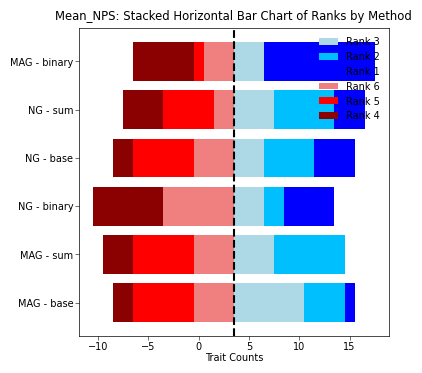

In [293]:
df = all_df.pivot_table(columns=['Group', 'Norm'], index='StudyEFO', values='Mean_NPS', aggfunc='mean').dropna().rank(ascending=False, axis=1)
plot_horizontal_stacked_ranks(df, 'Mean_NPS')

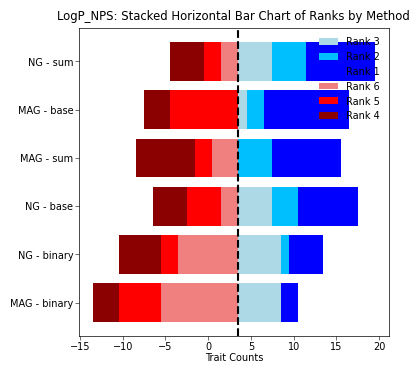

In [294]:
df = all_df.pivot_table(columns=['Group', 'Norm'], index='StudyEFO', values='logp_nps', aggfunc='mean').dropna().rank(ascending=False, axis=1)
plot_horizontal_stacked_ranks(df, 'LogP_NPS')

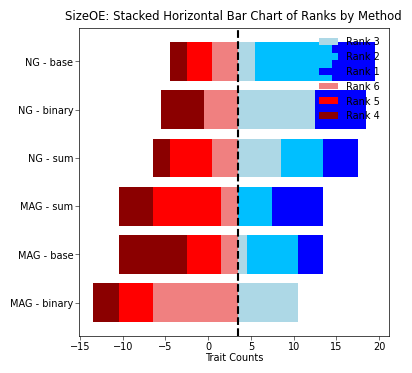

In [295]:
df = all_df.pivot_table(columns=['Group', 'Norm'], index='StudyEFO', values='SizeOE', aggfunc='mean').dropna().rank(ascending=False, axis=1)
plot_horizontal_stacked_ranks(df, 'SizeOE')

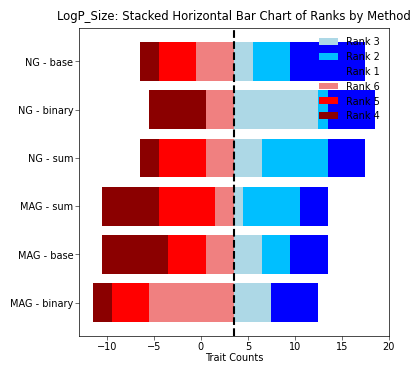

In [296]:
df = all_df.pivot_table(columns=['Group', 'Norm'], index='StudyEFO', values='logp_size', aggfunc='mean').dropna().rank(ascending=False, axis=1)
plot_horizontal_stacked_ranks(df, 'LogP_Size')

In [262]:
order = pd.DataFrame(x.apply(lambda y: np.sum([y[i]*i for i in x.columns]), axis=1).rank())
order = order.assign(idx=[i for i in range(6)])

In [266]:
order.sort_values(by=0).idx.values

array([5, 0, 2, 3, 4, 1])

In [274]:
x

In [204]:
all_df.pivot_table(columns=['Group', 'Norm', 'repeat'], index='StudyEFO', values='Mean_NPS').dropna().rank(axis=1, ascending=False)

Group                      MAG                                             \
Norm                      base             binary               sum         
repeat                       1     2     3      1     2     3     1     2   
StudyEFO                                                                    
GCST006366:EFO_0005213    12.0  17.0  15.0    9.0  11.0   5.0  13.0  16.0   
GCST007459:EFO_0006525     5.0   9.0   6.0    2.0   3.0   1.0   4.0   7.0   
GCST007710:EFO_0009863     6.0  11.0   8.0    2.0   5.0   1.0   7.0  12.0   
GCST008062:EFO_0004741     6.0   5.0   9.0    2.0   3.0   1.0   7.0   4.0   
GCST009414:EFO_0005213    14.0  15.0  12.0   18.0  13.0  10.0  17.0  16.0   
GCST90016673:EFO_0010821   7.0  16.0  15.0    3.0   6.0   5.0   8.0  14.0   
GCST90018627:EFO_0004237   4.0   8.0   7.0    2.0   3.0   1.0   5.0   9.0   
GCST90018714:EFO_0000731  15.0  18.0  11.0   13.0  17.0  10.0  14.0  16.0   
GCST90018728:EFO_0004741   7.0   4.0   9.0    3.0   1.0   2.0   6.0   5.0   
GCST90092502:EFO_0007117   2.0  15.0  17.0    1.0  14.0  16.0   3.0  13.0   
GCST90092503:EFO_0007117  15.0  17.0   9.0   13.0  16.0   8.0  14.0  18.0   
GCST90092504:EFO_0007117  15.0  16.0  12.0   17.0  18.0  11.0  14.0  13.0   
GCST90092505:EFO_0007117  11.0   1.0   4.0   10.0   3.0   6.0  12.0   2.0   
GCST90093316:EFO_0004887   9.0  13.0  17.0   10.0  15.0  18.0   8.0  12.0   
GCST90094960:EFO_0008036  17.0  15.0  10.0   18.0  11.0  12.0  16.0  14.0   
GCST90100525:EFO_0006332  18.0  14.0  11.0   17.0  13.0  10.0  16.0  15.0   
GCST90103632:EFO_0004741   6.0   4.0   9.0    2.0   1.0   3.0   7.0   5.0   
GCST90103754:EFO_0004343  10.0  12.0  14.0    2.0   8.0   9.0  11.0  13.0   
GCST90179151:EFO_0006525   7.0   9.0   6.0    2.0   3.0   1.0   4.0   8.0   
GCST90267352:EFO_0010821  17.0  14.0  15.0   10.0  12.0  11.0  18.0  16.0   
GCST90269581:EFO_0021898   7.0   6.0   8.0    3.0   2.0   1.0   4.0   9.0   
GCST90278623:EFO_0004741  10.0   5.0  11.0    3.0   1.0   2.0  12.0   4.0   
GCST90278649:EFO_0004343   8.0   7.0   5.0    3.0   2.0   1.0   9.0   6.0   

Group                             NG                                       \
Norm                            base             binary               sum   
repeat                       3     1     2     3      1     2     3     1   
StudyEFO                                                                    
GCST006366:EFO_0005213    14.0   2.0   8.0   4.0    6.0  10.0  18.0   1.0   
GCST007459:EFO_0006525     8.0  11.0  12.0  16.0   15.0  17.0  18.0  10.0   
GCST007710:EFO_0009863     9.0   4.0  16.0  15.0   10.0  18.0  13.0   3.0   
GCST008062:EFO_0004741     8.0  16.0  18.0  13.0   12.0  10.0  11.0  15.0   
GCST009414:EFO_0005213    11.0   2.0   4.0   7.0    6.0   1.0   9.0   3.0   
GCST90016673:EFO_0010821  13.0   1.0   9.0  10.0    4.0  18.0  17.0   2.0   
GCST90018627:EFO_0004237   6.0  13.0  11.0  14.0   16.5  16.5  18.0  10.0   
GCST90018714:EFO_0000731  12.0   5.0   8.0   2.0    9.0   6.0   1.0   4.0   
GCST90018728:EFO_0004741   8.0  14.0  13.0  17.0   10.0  11.0  16.0  15.0   
GCST90092502:EFO_0007117  18.0  11.0   5.0   6.0   10.0   8.0   7.0  12.0   
GCST90092503:EFO_0007117  12.0   3.0  10.0   5.0    1.0   7.0   4.0   2.0   
GCST90092504:EFO_0007117  10.0   7.0   5.0   3.0    8.0   4.0   1.0   9.0   
GCST90092505:EFO_0007117   5.0   8.0  17.0  15.0    7.0  18.0  13.0   9.0   
GCST90093316:EFO_0004887  16.0   1.0   5.0   7.0    2.0   6.0  14.0   3.0   
GCST90094960:EFO_0008036  13.0   6.0   4.0   8.0    2.0   1.0   7.0   5.0   
GCST90100525:EFO_0006332  12.0   6.0   7.0   3.0    5.0   4.0   2.0   9.0   
GCST90103632:EFO_0004741   8.0  11.0  14.0  17.0   12.0  13.0  16.0  10.0   
GCST90103754:EFO_0004343  15.0   7.0   3.0  18.0    5.0   1.0  16.0   6.0   
GCST90179151:EFO_0006525   5.0  13.0  11.0  18.0   15.0  14.0  16.0  12.0   
GCST90267352:EFO_0010821  13.0   4.0   7.0   3.0    1.0   9.0   6.0   2.0   
GCST90269581:EFO_0021898   5.0  12.0  13.0  15.0   18.0  16.0  10.0  11.

In [202]:
all_df.pivot_table(columns=['Group', 'Norm', 'repeat'], index='StudyEFO', values='Mean_NPS').dropna().rank(axis=1, ascending=False).mean().groupby(['Group', 'Norm']).mean()

Group  Norm  
MAG    base      10.420290
       binary     7.115942
       sum       10.289855
NG     base       9.507246
       binary     9.985507
       sum        9.681159
dtype: float64

<Axes: xlabel='Norm', ylabel='0'>

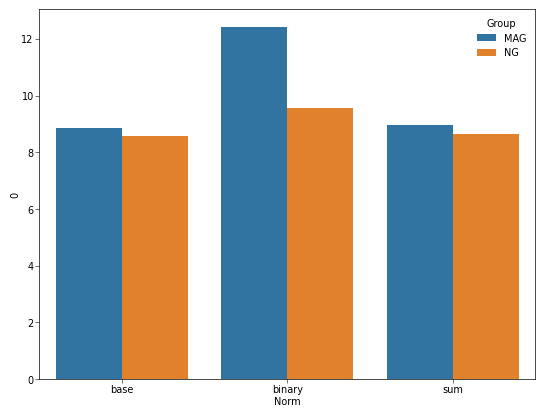

In [201]:
sns.barplot(pd.DataFrame(all_df.pivot_table(columns=['Group', 'Norm', 'repeat'], index='StudyEFO', values='logp_nps').dropna().rank(axis=1, ascending=False).mean().groupby(['Group', 'Norm']).mean()).reset_index(), x='Norm', y=0,hue='Group' )

In [187]:
all_df.pivot_table(columns=['Group', 'Norm', 'repeat'], index='StudyEFO', values='SizeOE').dropna().rank(axis=1, ascending=False).mean().groupby(['Group', 'Norm']).mean()

Group  Norm  
MAG    base       9.579710
       binary    12.536232
       sum        9.550725
NG     base       8.202899
       binary     8.971014
       sum        8.159420
dtype: float64

In [188]:
all_df.pivot_table(columns=['Group', 'Norm', 'repeat'], index='StudyEFO', values='logp_size').dropna().rank(axis=1, ascending=False).mean().groupby(['Group', 'Norm']).mean()

Group  Norm  
MAG    base      10.530303
       binary    11.075758
       sum       10.606061
NG     base       8.037879
       binary     8.704545
       sum        8.045455
dtype: float64

In [174]:
all_df.pivot_table(columns=['Group', 'Norm', 'repeat'], index='StudyEFO', values='Mean_NPS').dropna().rank(axis=1, ascending=False).mean().groupby('Norm').mean()


Norm
base      9.963768
binary    8.550725
sum       9.985507
dtype: float64

In [142]:
mag_all.pivot_table(columns=['Norm', 'repeat'], index='TraitR', values='Mean_NPS').dropna().rank(axis=1, ascending=False).mean().groupby('Norm').mean()

Norm
base      5.944444
binary    3.236111
sum       5.819444
dtype: float64

In [137]:
ng_all.pivot_table(columns=['Norm', 'repeat'], index='TraitR', values='logp_nps').dropna().rank(axis=1, ascending=False).mean().groupby('Norm').mean()

Norm
base      4.809524
binary    5.357143
sum       4.833333
dtype: float64

In [143]:
mag_all.pivot_table(columns=['Norm', 'repeat'], index='TraitR', values='logp_nps').dropna().rank(axis=1, ascending=False).mean().groupby('Norm').mean()

Norm
base      4.086957
binary    6.695652
sum       4.217391
dtype: float64

In [140]:
ng_all.pivot_table(columns=['Norm', 'repeat'], index='TraitR', values='SizeOE').dropna().rank(axis=1, ascending=False).mean().groupby('Norm').mean()

Norm
base      4.884058
binary    5.304348
sum       4.811594
dtype: float64

In [144]:
mag_all.pivot_table(columns=['Norm', 'repeat'], index='TraitR', values='SizeOE').dropna().rank(axis=1, ascending=False).mean().groupby('Norm').mean()

Norm
base      4.250000
binary    6.694444
sum       4.055556
dtype: float64

In [157]:
ng_all.pivot_table(columns=['Norm', 'repeat'], index='TraitR', values='logp_size').dropna().rank(axis=1, ascending=False).mean().groupby('Norm').mean()


Norm
base      4.891304
binary    5.282609
sum       4.826087
dtype: float64

In [158]:
mag_all.pivot_table(columns=['Norm', 'repeat'], index='TraitR', values='logp_size').dropna().rank(axis=1, ascending=False).mean().groupby('Norm').mean()

Norm
base      4.811594
binary    5.376812
sum       4.811594
dtype: float64

In [161]:
mag_all.head()

,TraitR,TraitC,Network,Transform,Norm,Mean_NPS,Null_mean_NPS,P_mean_NPS,Size,Null_Size,P_size,repeat,logp_nps,logp_size,SizeOE
0,magma_th103_GCST001791_EFO_0004531,magma_th103_GCST001791_EFO_0004531,pcnet2_0,neglog10,binary,0.320161,0.001831,5.508000e-81,481,259.892,1.212000e-54,1,80.259006,53.916497,1.850769
1,magma_th103_GCST006366_EFO_0005213,magma_th103_GCST006366_EFO_0005213,pcnet2_0,neglog10,binary,0.190775,0.000059,1.651000e-69,383,246.133,2.023000e-22,1,68.782253,21.694004,1.556069
2,magma_th103_GCST006891_EFO_0009397,magma_th103_GCST006891_EFO_0009397,pcnet2_0,neglog10,binary,0.034302,-0.005910,7.516000e-06,203,214.323,8.088000e-01,1,5.124013,0.092159,0.947169
3,magma_th103_GCST007367_EFO_0004608,magma_th103_GCST007367_EFO_0004608,pcnet2_0,neglog10,binary,0.060020,0.001218,1.570000e-12,272,220.020,7.390000e-05,1,11.804100,4.131356,1.236251
4,magma_th103_GCST007459_EFO_0006525,magma_th103_GCST007459_EFO_0006525,pcnet2_0,neglog10,binary,0.632710,0.000721,7.355000e-217,463,304.519,3.098000e-25,1,216.133417,24.508919,1.520431


In [160]:
mag_all.pivot_table(columns=['Norm', 'repeat'], index='TraitR', values='logp_size').dropna()

Norm                                       base                        \
repeat                                        1          2          3   
TraitR                                                                  
magma_th103_GCST006366_EFO_0005213    32.777024  34.334325  44.094636   
magma_th103_GCST007459_EFO_0006525    37.862329  19.322028  17.227605   
magma_th103_GCST007710_EFO_0009863    13.710411   6.547907   8.521145   
magma_th103_GCST008062_EFO_0004741    27.822752  34.852633  25.039054   
magma_th103_GCST009414_EFO_0005213    34.964570  22.118216  49.395882   
magma_th103_GCST010572_EFO_0010156    23.149293  20.385103  43.802995   
magma_th103_GCST90016673_EFO_0010821  37.207678  22.296107  21.982967   
magma_th103_GCST90018714_EFO_0000731   1.650140   2.342848   1.399463   
magma_th103_GCST90018728_EFO_0004741  22.245422  17.842241  14.731656   
magma_th103_GCST90092502_EFO_0007117  26.810229   0.000000   0.000000   
magma_th103_GCST90092503_EFO_0007117   0.626720   0.498941   0.313632   
magma_th103_GCST90092504_EFO_0007117   2.155834   2.115715   0.412177   
magma_th103_GCST90092505_EFO_0007117   0.000087  64.330033   0.227312   
magma_th103_GCST90093316_EFO_0004887   7.477425   4.733768   4.388383   
magma_th103_GCST90094960_EFO_0008036  12.964170  13.479910  17.858864   
magma_th103_GCST90100525_EFO_0006332   1.557677   4.529443   0.023604   
magma_th103_GCST90103632_EFO_0004741  30.763463  26.173731  27.341798   
magma_th103_GCST90103754_EFO_0004343   5.640354   2.096584   0.787280   
magma_th103_GCST90179151_EFO_0006525  51.941954  53.162854  45.617803   
magma_th103_GCST90267352_EFO_0010821  29.262648  13.522589  28.344862   
magma_th103_GCST90269581_EFO_0021898  50.576263  54.990124  63.690796   
magma_th103_GCST90278623_EFO_0004741  15.151441  22.327164  20.513428   
magma_th103_GCST90278649_EFO_0004343  17.535361  18.697886  27.027797   

Norm                                     binary                        \
repeat                                        1          2          3   
TraitR                                                                  
magma_th103_GCST006366_EFO_0005213    21.694004  14.476644  31.174899   
magma_th103_GCST007459_EFO_0006525    24.508919  20.260982  15.370896   
magma_th103_GCST007710_EFO_0009863    10.721475   5.297311  13.222646   
magma_th103_GCST008062_EFO_0004741    31.768276  34.412851  48.823619   
magma_th103_GCST009414_EFO_0005213    32.117646  26.365321  34.177505   
magma_th103_GCST010572_EFO_0010156     5.425969   6.847406  26.870955   
magma_th103_GCST90016673_EFO_0010821  30.809388  14.607127  24.106016   
magma_th103_GCST90018714_EFO_0000731   3.134304   0.362610   0.486516   
magma_th103_GCST90018728_EFO_0004741  21.052910  10.771343  10.480434   
magma_th103_GCST90092502_EFO_0007117  37.451856   0.000000   0.000000   
magma_th103_GCST90092503_EFO_0007117   0.734710   0.658565   0.121478   
magma_th103_GCST90092504_EFO_0007117   1.655411   1.150458   1.028168   
magma_th103_GCST90092505_EFO_0007117   0.000174  54.266562   0.122513   
magma_th103_GCST90093316_EFO_0004887   9.520425   3.713319   1.592949   
magma_th103_GCST90094960_EFO_0008036   4.222283  10.379760   7.222863   
magma_th103_GCST90100525_EFO_0006332   0.947306   4.881405   0.067831   
magma_th103_GCST90103632_EFO_0004741  65.399354  52.262569  62.279593   
magma_th103_GCST90103754_EFO_0004343   6.597223   3.557520   1.309007   
magma_th103_GCST90179151_EFO_0006525  56.108295  48.048371  43.296365   
magma_th103_GCST90267352_EFO_0010821  19.185752  17.733533  26.159016   
magma_th103_GCST90269581_EFO_0021898  40.091837  40.288193  60.464959   
magma_th103_GCST90278623_EFO_0004741  16.435571  24.024982  23.620513   
magma_th103_GCST90278649_EFO_0004343  12.240332  21.122917  19.725611   

Norm                                        sum                        
repeat                                        1          2          3  
TraitR                                                    